# Setup

In [1]:
# Define Parameters
batch_size = 128
epochs = 200
task = 'Humanitarian_Classification'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
import torch
import torch.nn as nn
import torch.optim
import torchvision.models as models
import torchvision.transforms as transforms
import warnings
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

device = torch.device("cuda:0")
warnings.filterwarnings("ignore")

# Data Loading

In [3]:
hm_train_path = '/work/u9562361/crisis_vision_benchmarks/tasks/humanitarian/consolidated/consolidated_hum_train_final.tsv'
hm_test_path = '/work/u9562361/crisis_vision_benchmarks/tasks/humanitarian/consolidated/consolidated_hum_test_final.tsv'
hm_dev_path = '/work/u9562361/crisis_vision_benchmarks/tasks/humanitarian/consolidated/consolidated_hum_dev_final.tsv'

train_label = pd.read_table(hm_train_path)
test_label = pd.read_table(hm_test_path)
dev_label = pd.read_table(hm_dev_path)

print(train_label.shape)
print(test_label.shape)
print(dev_label.shape)

(12618, 4)
(2922, 4)
(1229, 4)


In [4]:
class_label_map = {"affected_injured_or_dead_people": 3, "rescue_volunteering_or_donation_effort": 2, "infrastructure_and_utility_damage": 1, "not_humanitarian": 0}

def get_data(pd_label, class_label_map):
    image_path = pd_label['image_path']
    class_label = pd_label['class_label']

    X, y, valid_indices = [], [], []

    tfms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    for i in tqdm(range(len(image_path))):
        path = os.path.join('/work/u9562361/crisis_vision_benchmarks/', image_path[i])
        try:
            img = Image.open(path)
            if img is None:
                print(f"Error reading image: {path}")
                continue
            img = img.resize((224, 224))
            img = img.convert("RGB")
            img = np.array(img, dtype=np.float32) / 255.0
            img = tfms(img) 
            X.append(img)
            valid_indices.append(i)
        except Exception as e:
            print(f"Error opening image: {path} - {str(e)}")
            continue

    print(X[0].shape)
    X = np.stack(X)
    print(X.shape)

    for idx in tqdm(valid_indices):
        label = class_label[idx]
        if label not in class_label_map:
            print(f"Error: Unknown class label: {label}")
            continue
        y.append(class_label_map[label])

    y = np.array(y, dtype=np.int64)
    print(y.shape)

    return X, y

In [5]:
X_train, y_train = get_data(train_label, class_label_map)
X_test, y_test = get_data(test_label, class_label_map)
X_dev, y_dev = get_data(dev_label, class_label_map)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
trainset = TensorDataset(X_train, y_train)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)
testset = TensorDataset(X_test, y_test)

X_dev = torch.tensor(X_dev, dtype=torch.float32)
y_dev = torch.tensor(y_dev, dtype=torch.int64)
devset = TensorDataset(X_dev, y_dev)

100%|██████████| 12618/12618 [06:23<00:00, 32.92it/s]


torch.Size([3, 224, 224])
(12618, 3, 224, 224)


100%|██████████| 12618/12618 [00:00<00:00, 391346.38it/s]


(12618,)


100%|██████████| 2922/2922 [01:31<00:00, 31.80it/s]


torch.Size([3, 224, 224])
(2922, 3, 224, 224)


100%|██████████| 2922/2922 [00:00<00:00, 465732.71it/s]


(2922,)


 71%|███████   | 871/1229 [00:25<00:11, 31.19it/s]

Error opening image: /work/u9562361/crisis_vision_benchmarks/data/multimodal-deep-learning-disaster-response-mouzannar/multimodal/damaged_infrastructure/images/wreckedcar_2017-02-23_21-15-25.jpg - image file is truncated (0 bytes not processed)


100%|██████████| 1229/1229 [00:39<00:00, 31.25it/s]


torch.Size([3, 224, 224])
(1228, 3, 224, 224)


100%|██████████| 1228/1228 [00:00<00:00, 463059.00it/s]


(1228,)


In [6]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
devloader = DataLoader(devset, batch_size=batch_size, shuffle=True, num_workers=4)

# ResNet50_pretrained

In [7]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [8]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [9]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_ResNet50_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [10]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 0.8514 - accuracy: 68.06% - val_loss: 0.6907 - val_accuracy: 73.20% - time: 44.98s
Epoch 2/100 - loss: 0.5635 - accuracy: 78.71% - val_loss: 0.6184 - val_accuracy: 76.28% - time: 44.78s
Epoch 3/100 - loss: 0.4187 - accuracy: 85.20% - val_loss: 0.6172 - val_accuracy: 76.08% - time: 44.77s
Epoch 4/100 - loss: 0.2893 - accuracy: 90.69% - val_loss: 0.6468 - val_accuracy: 76.11% - time: 44.83s
Epoch 5/100 - loss: 0.1888 - accuracy: 94.74% - val_loss: 0.6824 - val_accuracy: 76.11% - time: 44.72s
Epoch 6/100 - loss: 0.1203 - accuracy: 97.01% - val_loss: 0.7340 - val_accuracy: 76.21% - time: 44.83s
Epoch 7/100 - loss: 0.0781 - accuracy: 98.39% - val_loss: 0.7646 - val_accuracy: 76.01% - time: 44.95s
Epoch 8/100 - loss: 0.0523 - accuracy: 98.99% - val_loss: 0.7951 - val_accuracy: 76.04% - time: 44.76s
Epoch 9/100 - loss: 0.0365 - accuracy: 99.39% - val_loss: 0.8308 - val_accuracy: 75.22% - time: 44.79s
Epoch 10/100 - loss: 0.0288 - accuracy: 99.53% - val_loss: 0.8479 - val_a

Epoch 80/100 - loss: 0.0079 - accuracy: 99.83% - val_loss: 0.9290 - val_accuracy: 75.19% - time: 44.74s
Epoch 81/100 - loss: 0.0078 - accuracy: 99.85% - val_loss: 0.9268 - val_accuracy: 75.70% - time: 44.83s
Epoch 82/100 - loss: 0.0079 - accuracy: 99.83% - val_loss: 0.9231 - val_accuracy: 75.70% - time: 44.87s
Epoch 83/100 - loss: 0.0076 - accuracy: 99.88% - val_loss: 0.9283 - val_accuracy: 75.77% - time: 44.85s
Epoch 84/100 - loss: 0.0078 - accuracy: 99.83% - val_loss: 0.9226 - val_accuracy: 75.53% - time: 44.90s
Epoch 85/100 - loss: 0.0072 - accuracy: 99.89% - val_loss: 0.9277 - val_accuracy: 75.33% - time: 44.86s
Epoch 86/100 - loss: 0.0074 - accuracy: 99.87% - val_loss: 0.9264 - val_accuracy: 75.84% - time: 44.92s
Epoch 87/100 - loss: 0.0074 - accuracy: 99.86% - val_loss: 0.9232 - val_accuracy: 75.87% - time: 44.79s
Epoch 88/100 - loss: 0.0078 - accuracy: 99.85% - val_loss: 0.9233 - val_accuracy: 75.63% - time: 44.82s
Epoch 89/100 - loss: 0.0076 - accuracy: 99.88% - val_loss: 0.925

In [11]:
print(task + '_ResNet50_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_ResNet50_pretrained Classification Report:')
print(cr)

Humanitarian_Classification_ResNet50_pretrained Performance:
Accuracy : 76.43%
F1-Score : 75.91%
Humanitarian_Classification_ResNet50_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1550
           1       0.74      0.75      0.74       821
           2       0.63      0.55      0.59       391
           3       0.50      0.37      0.42       160

    accuracy                           0.76      2922
   macro avg       0.67      0.63      0.65      2922
weighted avg       0.75      0.76      0.76      2922



## Visualize Results & Confusion Matrix

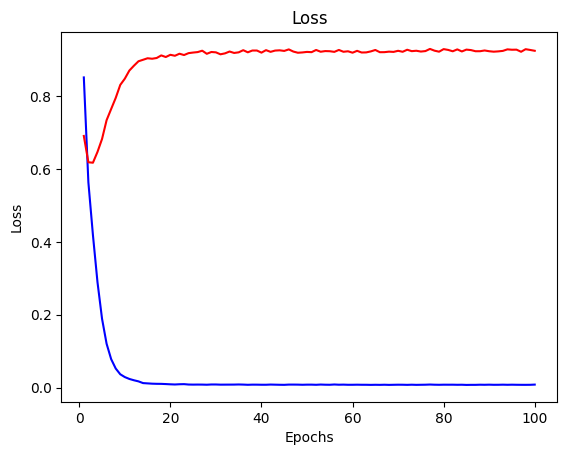

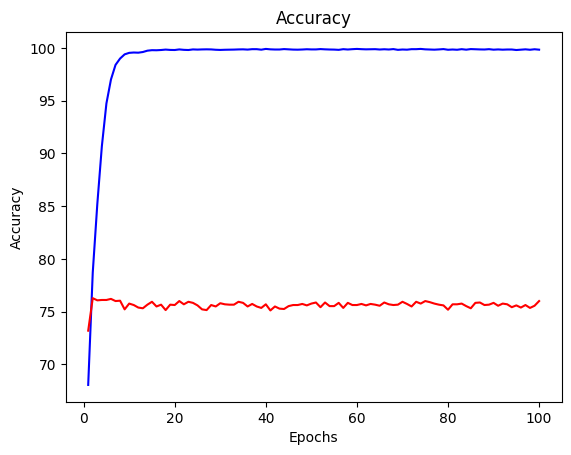

In [12]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Humanitarian_Classification_ResNet50_pretrained Confusion Matrix:

affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0


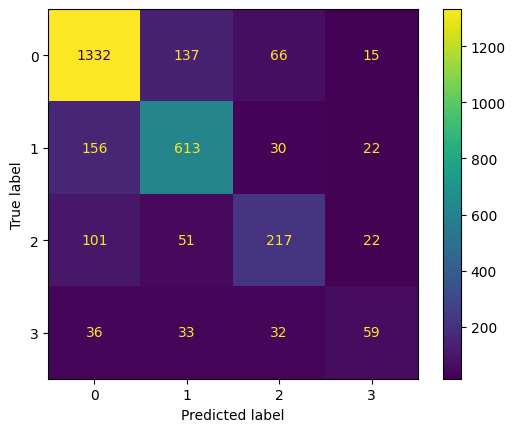

In [13]:
# "affected_injured_or_dead_people": 3, "rescue_volunteering_or_donation_effort": 2, "infrastructure_and_utility_damage": 1, "not_humanitarian": 0
print(task + '_ResNet50_pretrained Confusion Matrix:\n')
print('affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# EfficientNetb1_pretrained

In [14]:
model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [15]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [16]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_EfficientNetb1_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [17]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 1.3207 - accuracy: 39.21% - val_loss: 1.2287 - val_accuracy: 53.80% - time: 38.11s
Epoch 2/100 - loss: 1.1328 - accuracy: 59.82% - val_loss: 1.0807 - val_accuracy: 62.83% - time: 38.06s
Epoch 3/100 - loss: 0.9883 - accuracy: 65.59% - val_loss: 0.9606 - val_accuracy: 65.98% - time: 38.11s
Epoch 4/100 - loss: 0.8828 - accuracy: 68.51% - val_loss: 0.8760 - val_accuracy: 68.51% - time: 38.18s
Epoch 5/100 - loss: 0.7978 - accuracy: 70.99% - val_loss: 0.8216 - val_accuracy: 69.16% - time: 38.02s
Epoch 6/100 - loss: 0.7419 - accuracy: 72.86% - val_loss: 0.7750 - val_accuracy: 70.23% - time: 38.23s
Epoch 7/100 - loss: 0.6993 - accuracy: 74.07% - val_loss: 0.7418 - val_accuracy: 71.56% - time: 37.91s
Epoch 8/100 - loss: 0.6551 - accuracy: 75.63% - val_loss: 0.7157 - val_accuracy: 72.18% - time: 38.11s
Epoch 9/100 - loss: 0.6250 - accuracy: 76.62% - val_loss: 0.6920 - val_accuracy: 72.72% - time: 38.13s
Epoch 10/100 - loss: 0.5977 - accuracy: 77.22% - val_loss: 0.6774 - val_a

Epoch 80/100 - loss: 0.1725 - accuracy: 94.40% - val_loss: 0.6929 - val_accuracy: 76.42% - time: 38.26s
Epoch 81/100 - loss: 0.1727 - accuracy: 94.33% - val_loss: 0.6942 - val_accuracy: 76.39% - time: 38.11s
Epoch 82/100 - loss: 0.1710 - accuracy: 94.58% - val_loss: 0.6964 - val_accuracy: 76.56% - time: 38.32s
Epoch 83/100 - loss: 0.1747 - accuracy: 94.17% - val_loss: 0.6894 - val_accuracy: 76.42% - time: 38.14s
Epoch 84/100 - loss: 0.1716 - accuracy: 94.70% - val_loss: 0.6912 - val_accuracy: 76.28% - time: 38.21s
Epoch 85/100 - loss: 0.1737 - accuracy: 94.17% - val_loss: 0.6927 - val_accuracy: 76.42% - time: 38.21s
Epoch 86/100 - loss: 0.1727 - accuracy: 94.48% - val_loss: 0.6874 - val_accuracy: 76.28% - time: 38.12s
Epoch 87/100 - loss: 0.1711 - accuracy: 94.37% - val_loss: 0.6958 - val_accuracy: 76.66% - time: 38.18s
Epoch 88/100 - loss: 0.1755 - accuracy: 94.34% - val_loss: 0.6899 - val_accuracy: 76.28% - time: 38.24s
Epoch 89/100 - loss: 0.1736 - accuracy: 94.36% - val_loss: 0.694

In [18]:
print(task + '_EfficientNetb1_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_EfficientNetb1_pretrained Classification Report:')
print(cr)

Humanitarian_Classification_EfficientNetb1_pretrained Performance:
Accuracy : 76.90%
F1-Score : 76.56%
Humanitarian_Classification_EfficientNetb1_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1550
           1       0.74      0.76      0.75       821
           2       0.59      0.62      0.60       391
           3       0.56      0.44      0.49       160

    accuracy                           0.76      2922
   macro avg       0.68      0.66      0.67      2922
weighted avg       0.76      0.76      0.76      2922



## Visualize Results & Confusion Matrix

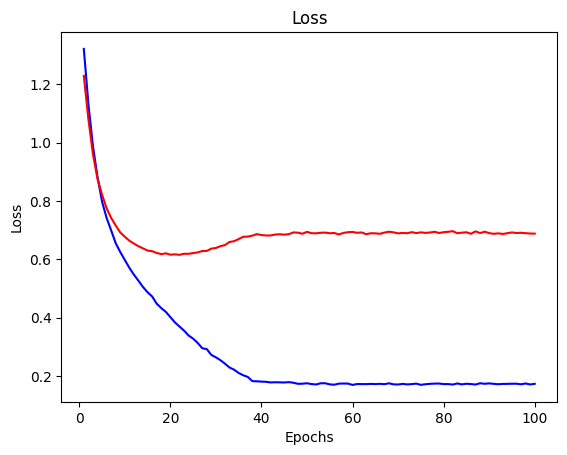

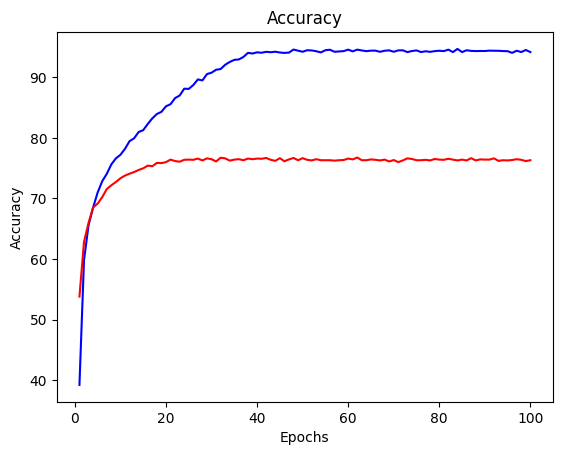

In [19]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Humanitarian_Classification_EfficientNetb1_pretrained Confusion Matrix:

affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0


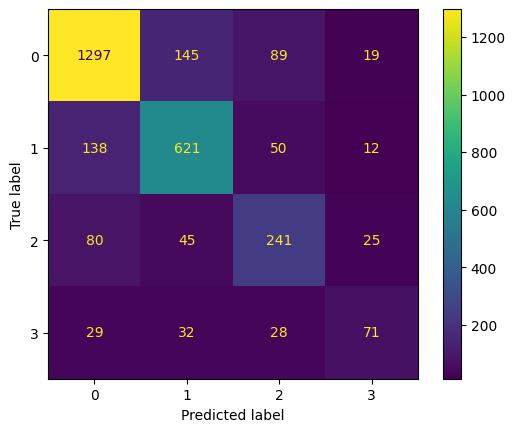

In [20]:
# "affected_injured_or_dead_people": 3, "rescue_volunteering_or_donation_effort": 2, "infrastructure_and_utility_damage": 1, "not_humanitarian": 0
print(task + '_EfficientNetb1_pretrained Confusion Matrix:\n')
print('affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# VGG16_pretrained

In [21]:
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [22]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [23]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_VGG16_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [24]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 0.8953 - accuracy: 63.01% - val_loss: 0.7094 - val_accuracy: 70.02% - time: 63.37s
Epoch 2/100 - loss: 0.6533 - accuracy: 73.53% - val_loss: 0.6401 - val_accuracy: 73.44% - time: 63.35s
Epoch 3/100 - loss: 0.5523 - accuracy: 77.92% - val_loss: 0.6119 - val_accuracy: 74.40% - time: 63.35s
Epoch 4/100 - loss: 0.4698 - accuracy: 81.68% - val_loss: 0.6162 - val_accuracy: 74.91% - time: 63.40s
Epoch 5/100 - loss: 0.4055 - accuracy: 84.17% - val_loss: 0.6183 - val_accuracy: 75.15% - time: 63.36s
Epoch 6/100 - loss: 0.3257 - accuracy: 87.58% - val_loss: 0.6399 - val_accuracy: 75.09% - time: 63.33s
Epoch 7/100 - loss: 0.2562 - accuracy: 90.39% - val_loss: 0.6749 - val_accuracy: 75.87% - time: 63.31s
Epoch 8/100 - loss: 0.1965 - accuracy: 92.83% - val_loss: 0.7351 - val_accuracy: 75.70% - time: 63.41s
Epoch 9/100 - loss: 0.1470 - accuracy: 94.90% - val_loss: 0.7704 - val_accuracy: 74.50% - time: 63.42s
Epoch 10/100 - loss: 0.1121 - accuracy: 96.13% - val_loss: 0.8310 - val_a

Epoch 80/100 - loss: 0.0159 - accuracy: 99.51% - val_loss: 1.2728 - val_accuracy: 75.70% - time: 63.25s
Epoch 81/100 - loss: 0.0156 - accuracy: 99.44% - val_loss: 1.2721 - val_accuracy: 75.67% - time: 63.46s
Epoch 82/100 - loss: 0.0147 - accuracy: 99.52% - val_loss: 1.2717 - val_accuracy: 75.74% - time: 63.41s
Epoch 83/100 - loss: 0.0158 - accuracy: 99.52% - val_loss: 1.2716 - val_accuracy: 75.74% - time: 63.42s
Epoch 84/100 - loss: 0.0141 - accuracy: 99.56% - val_loss: 1.2720 - val_accuracy: 75.74% - time: 63.35s
Epoch 85/100 - loss: 0.0146 - accuracy: 99.55% - val_loss: 1.2721 - val_accuracy: 75.74% - time: 63.54s
Epoch 86/100 - loss: 0.0158 - accuracy: 99.52% - val_loss: 1.2719 - val_accuracy: 75.77% - time: 63.43s
Epoch 87/100 - loss: 0.0143 - accuracy: 99.61% - val_loss: 1.2717 - val_accuracy: 75.70% - time: 63.55s
Epoch 88/100 - loss: 0.0149 - accuracy: 99.53% - val_loss: 1.2722 - val_accuracy: 75.70% - time: 63.39s
Epoch 89/100 - loss: 0.0141 - accuracy: 99.55% - val_loss: 1.272

In [25]:
print(task + '_VGG16_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_VGG16_pretrained Classification Report:')
print(cr)

Humanitarian_Classification_VGG16_pretrained Performance:
Accuracy : 76.28%
F1-Score : 75.66%
Humanitarian_Classification_VGG16_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1550
           1       0.74      0.76      0.75       821
           2       0.64      0.55      0.59       391
           3       0.48      0.30      0.37       160

    accuracy                           0.76      2922
   macro avg       0.67      0.62      0.64      2922
weighted avg       0.75      0.76      0.75      2922



## Visualize Results & Confusion Matrix

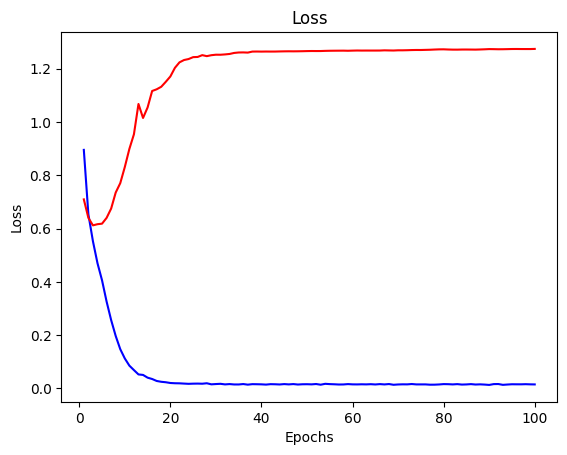

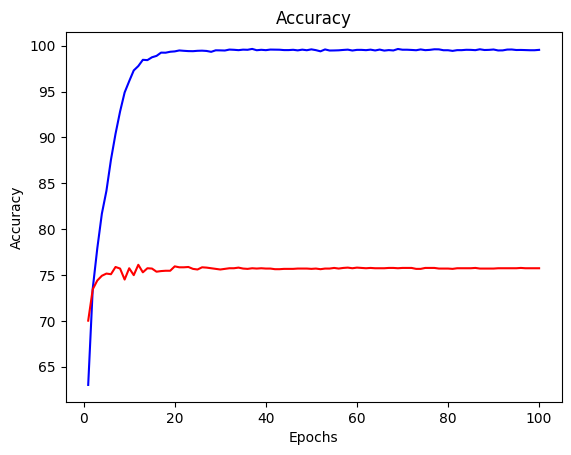

In [26]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Humanitarian_Classification_VGG16_pretrained Confusion Matrix:

affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0


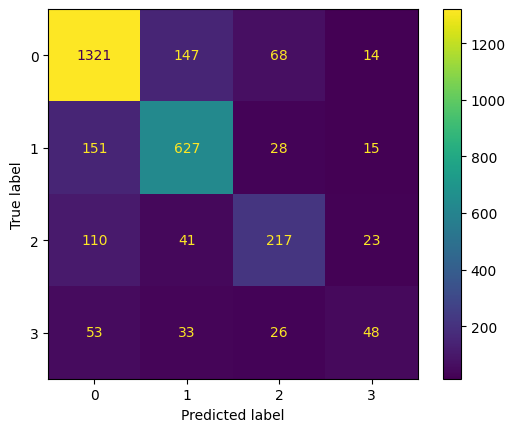

In [27]:
# "affected_injured_or_dead_people": 3, "rescue_volunteering_or_donation_effort": 2, "infrastructure_and_utility_damage": 1, "not_humanitarian": 0
print(task + '_VGG16_pretrained Confusion Matrix:\n')
print('affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# ResNet18_pretrained

In [28]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [29]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [30]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_ResNet18_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [31]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 0.9823 - accuracy: 61.21% - val_loss: 0.8238 - val_accuracy: 68.96% - time: 19.15s
Epoch 2/100 - loss: 0.6890 - accuracy: 73.59% - val_loss: 0.7071 - val_accuracy: 72.72% - time: 19.03s
Epoch 3/100 - loss: 0.5881 - accuracy: 77.97% - val_loss: 0.6691 - val_accuracy: 73.17% - time: 19.14s
Epoch 4/100 - loss: 0.5168 - accuracy: 80.77% - val_loss: 0.6490 - val_accuracy: 74.20% - time: 19.05s
Epoch 5/100 - loss: 0.4532 - accuracy: 83.73% - val_loss: 0.6421 - val_accuracy: 74.61% - time: 19.07s
Epoch 6/100 - loss: 0.3973 - accuracy: 86.23% - val_loss: 0.6414 - val_accuracy: 74.88% - time: 19.01s
Epoch 7/100 - loss: 0.3454 - accuracy: 88.72% - val_loss: 0.6518 - val_accuracy: 74.47% - time: 19.03s
Epoch 8/100 - loss: 0.2945 - accuracy: 90.63% - val_loss: 0.6520 - val_accuracy: 75.05% - time: 19.01s
Epoch 9/100 - loss: 0.2487 - accuracy: 92.68% - val_loss: 0.6736 - val_accuracy: 74.47% - time: 19.04s
Epoch 10/100 - loss: 0.2111 - accuracy: 94.25% - val_loss: 0.6829 - val_a

Epoch 80/100 - loss: 0.0285 - accuracy: 99.73% - val_loss: 0.8493 - val_accuracy: 74.37% - time: 19.20s
Epoch 81/100 - loss: 0.0280 - accuracy: 99.75% - val_loss: 0.8385 - val_accuracy: 74.44% - time: 18.96s
Epoch 82/100 - loss: 0.0291 - accuracy: 99.77% - val_loss: 0.8431 - val_accuracy: 74.37% - time: 18.99s
Epoch 83/100 - loss: 0.0283 - accuracy: 99.67% - val_loss: 0.8438 - val_accuracy: 74.30% - time: 18.98s
Epoch 84/100 - loss: 0.0285 - accuracy: 99.79% - val_loss: 0.8402 - val_accuracy: 74.54% - time: 18.98s
Epoch 85/100 - loss: 0.0280 - accuracy: 99.75% - val_loss: 0.8435 - val_accuracy: 74.26% - time: 19.09s
Epoch 86/100 - loss: 0.0284 - accuracy: 99.68% - val_loss: 0.8450 - val_accuracy: 74.33% - time: 19.13s
Epoch 87/100 - loss: 0.0284 - accuracy: 99.69% - val_loss: 0.8429 - val_accuracy: 74.23% - time: 18.96s
Epoch 88/100 - loss: 0.0283 - accuracy: 99.71% - val_loss: 0.8413 - val_accuracy: 74.26% - time: 19.11s
Epoch 89/100 - loss: 0.0295 - accuracy: 99.75% - val_loss: 0.843

In [32]:
print(task + '_ResNet18_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_ResNet18_pretrained Classification Report:')
print(cr)

Humanitarian_Classification_ResNet18_pretrained Performance:
Accuracy : 75.22%
F1-Score : 74.25%
Humanitarian_Classification_ResNet18_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1550
           1       0.71      0.75      0.73       821
           2       0.60      0.48      0.53       391
           3       0.46      0.31      0.37       160

    accuracy                           0.74      2922
   macro avg       0.64      0.59      0.61      2922
weighted avg       0.73      0.74      0.73      2922



## Visualize Results & Confusion Matrix

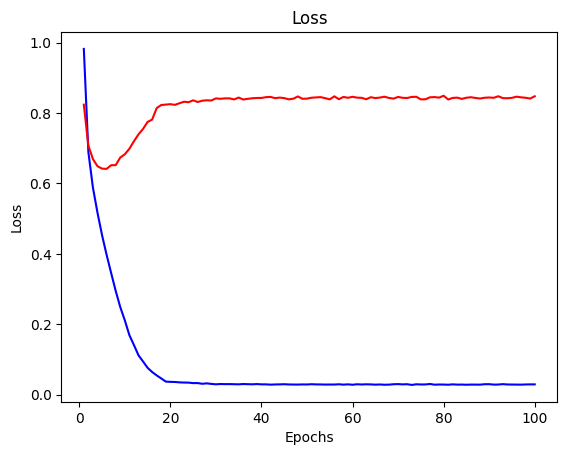

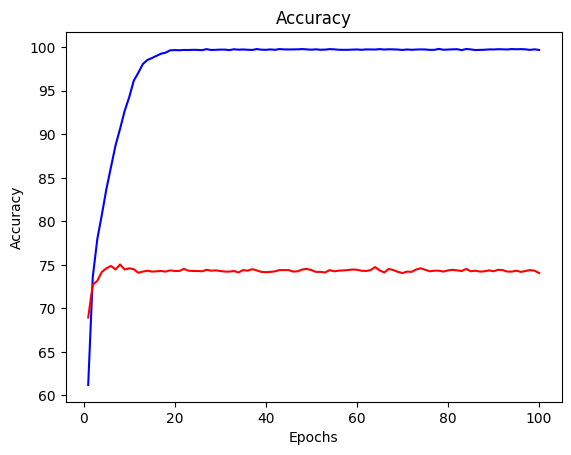

In [33]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Humanitarian_Classification_ResNet18_pretrained Confusion Matrix:

affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0


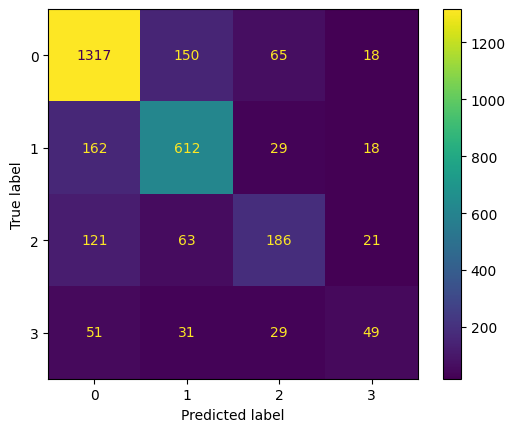

In [34]:
# "affected_injured_or_dead_people": 3, "rescue_volunteering_or_donation_effort": 2, "infrastructure_and_utility_damage": 1, "not_humanitarian": 0
print(task + '_ResNet18_pretrained Confusion Matrix:\n')
print('affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# ResNet101_pretrained

In [35]:
model = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [36]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [37]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_ResNet101_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [38]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 0.8927 - accuracy: 66.41% - val_loss: 0.6909 - val_accuracy: 73.20% - time: 69.33s
Epoch 2/100 - loss: 0.5255 - accuracy: 81.15% - val_loss: 0.6237 - val_accuracy: 75.63% - time: 69.28s
Epoch 3/100 - loss: 0.3366 - accuracy: 89.30% - val_loss: 0.6388 - val_accuracy: 76.15% - time: 69.32s
Epoch 4/100 - loss: 0.1932 - accuracy: 94.67% - val_loss: 0.6715 - val_accuracy: 75.84% - time: 69.26s
Epoch 5/100 - loss: 0.1072 - accuracy: 97.56% - val_loss: 0.7124 - val_accuracy: 75.91% - time: 69.31s
Epoch 6/100 - loss: 0.0615 - accuracy: 98.73% - val_loss: 0.7512 - val_accuracy: 75.84% - time: 69.34s
Epoch 7/100 - loss: 0.0389 - accuracy: 99.25% - val_loss: 0.7762 - val_accuracy: 75.84% - time: 69.36s
Epoch 8/100 - loss: 0.0288 - accuracy: 99.45% - val_loss: 0.8196 - val_accuracy: 76.01% - time: 69.26s
Epoch 9/100 - loss: 0.0228 - accuracy: 99.51% - val_loss: 0.8237 - val_accuracy: 75.50% - time: 69.33s
Epoch 10/100 - loss: 0.0178 - accuracy: 99.63% - val_loss: 0.8336 - val_a

Epoch 80/100 - loss: 0.0054 - accuracy: 99.87% - val_loss: 0.9024 - val_accuracy: 75.77% - time: 69.24s
Epoch 81/100 - loss: 0.0054 - accuracy: 99.87% - val_loss: 0.9006 - val_accuracy: 76.04% - time: 69.23s
Epoch 82/100 - loss: 0.0055 - accuracy: 99.90% - val_loss: 0.9025 - val_accuracy: 76.21% - time: 69.27s
Epoch 83/100 - loss: 0.0056 - accuracy: 99.85% - val_loss: 0.9017 - val_accuracy: 76.04% - time: 69.26s
Epoch 84/100 - loss: 0.0053 - accuracy: 99.87% - val_loss: 0.8983 - val_accuracy: 75.67% - time: 69.36s
Epoch 85/100 - loss: 0.0047 - accuracy: 99.95% - val_loss: 0.8943 - val_accuracy: 76.15% - time: 69.25s
Epoch 86/100 - loss: 0.0052 - accuracy: 99.88% - val_loss: 0.8902 - val_accuracy: 75.94% - time: 69.28s
Epoch 87/100 - loss: 0.0053 - accuracy: 99.88% - val_loss: 0.9051 - val_accuracy: 76.15% - time: 69.31s
Epoch 88/100 - loss: 0.0055 - accuracy: 99.83% - val_loss: 0.9014 - val_accuracy: 76.28% - time: 69.23s
Epoch 89/100 - loss: 0.0052 - accuracy: 99.90% - val_loss: 0.899

In [39]:
print(task + '_ResNet101_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_ResNet101_pretrained Classification Report:')
print(cr)

Humanitarian_Classification_ResNet101_pretrained Performance:
Accuracy : 76.79%
F1-Score : 75.95%
Humanitarian_Classification_ResNet101_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1550
           1       0.74      0.74      0.74       821
           2       0.63      0.54      0.58       391
           3       0.50      0.46      0.48       160

    accuracy                           0.76      2922
   macro avg       0.67      0.65      0.66      2922
weighted avg       0.75      0.76      0.76      2922



## Visualize Results & Confusion Matrix

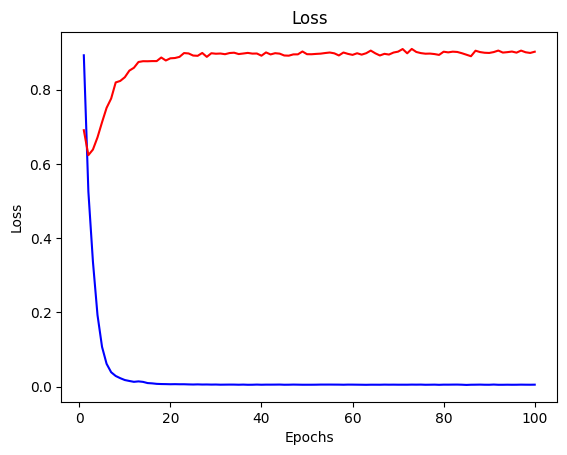

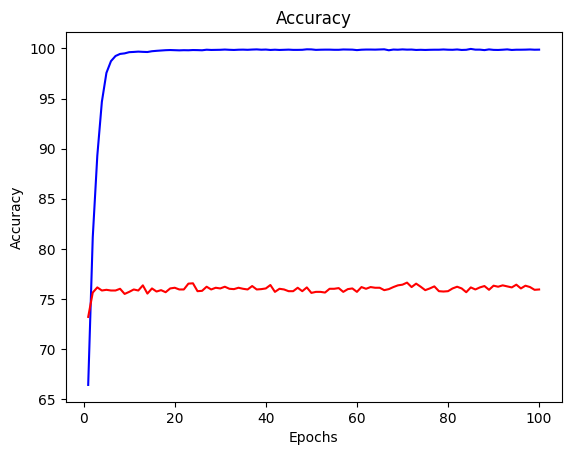

In [40]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Humanitarian_Classification_ResNet101_pretrained Confusion Matrix:

affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0


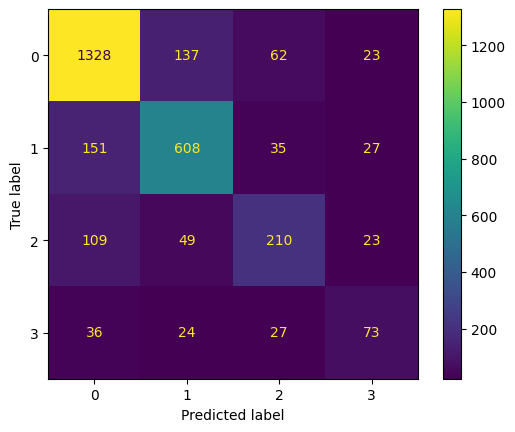

In [41]:
# "affected_injured_or_dead_people": 3, "rescue_volunteering_or_donation_effort": 2, "infrastructure_and_utility_damage": 1, "not_humanitarian": 0
print(task + '_ResNet101_pretrained Confusion Matrix:\n')
print('affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# DenseNet121_pretrained

In [7]:
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [8]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [9]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_DenseNet121_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [10]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 1.1678 - accuracy: 51.62% - val_loss: 0.9692 - val_accuracy: 64.61% - time: 50.25s
Epoch 2/100 - loss: 0.7870 - accuracy: 71.19% - val_loss: 0.7707 - val_accuracy: 70.94% - time: 49.81s
Epoch 3/100 - loss: 0.6531 - accuracy: 75.87% - val_loss: 0.6971 - val_accuracy: 72.72% - time: 49.63s
Epoch 4/100 - loss: 0.5735 - accuracy: 78.78% - val_loss: 0.6637 - val_accuracy: 73.79% - time: 49.67s
Epoch 5/100 - loss: 0.5110 - accuracy: 81.26% - val_loss: 0.6449 - val_accuracy: 74.74% - time: 49.71s
Epoch 6/100 - loss: 0.4583 - accuracy: 83.44% - val_loss: 0.6323 - val_accuracy: 74.85% - time: 49.87s
Epoch 7/100 - loss: 0.4022 - accuracy: 86.23% - val_loss: 0.6307 - val_accuracy: 75.02% - time: 49.82s
Epoch 8/100 - loss: 0.3554 - accuracy: 88.26% - val_loss: 0.6331 - val_accuracy: 75.33% - time: 49.60s
Epoch 9/100 - loss: 0.3090 - accuracy: 90.30% - val_loss: 0.6399 - val_accuracy: 75.60% - time: 49.79s
Epoch 10/100 - loss: 0.2677 - accuracy: 92.26% - val_loss: 0.6494 - val_a

Epoch 80/100 - loss: 0.0293 - accuracy: 99.68% - val_loss: 0.8560 - val_accuracy: 74.33% - time: 49.80s
Epoch 81/100 - loss: 0.0286 - accuracy: 99.68% - val_loss: 0.8548 - val_accuracy: 74.30% - time: 49.74s
Epoch 82/100 - loss: 0.0290 - accuracy: 99.69% - val_loss: 0.8565 - val_accuracy: 74.64% - time: 49.80s
Epoch 83/100 - loss: 0.0286 - accuracy: 99.68% - val_loss: 0.8620 - val_accuracy: 74.26% - time: 49.92s
Epoch 84/100 - loss: 0.0287 - accuracy: 99.70% - val_loss: 0.8503 - val_accuracy: 74.54% - time: 49.77s
Epoch 85/100 - loss: 0.0304 - accuracy: 99.68% - val_loss: 0.8581 - val_accuracy: 74.26% - time: 49.71s
Epoch 86/100 - loss: 0.0294 - accuracy: 99.73% - val_loss: 0.8592 - val_accuracy: 74.44% - time: 49.73s
Epoch 87/100 - loss: 0.0303 - accuracy: 99.64% - val_loss: 0.8567 - val_accuracy: 74.33% - time: 49.63s
Epoch 88/100 - loss: 0.0289 - accuracy: 99.66% - val_loss: 0.8542 - val_accuracy: 74.16% - time: 49.63s
Epoch 89/100 - loss: 0.0294 - accuracy: 99.66% - val_loss: 0.856

In [11]:
print(task + '_DenseNet121_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_DenseNet121_pretrained Classification Report:')
print(cr)

Humanitarian_Classification_DenseNet121_pretrained Performance:
Accuracy : 76.13%
F1-Score : 75.16%
Humanitarian_Classification_DenseNet121_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1550
           1       0.74      0.72      0.73       821
           2       0.59      0.50      0.54       391
           3       0.46      0.33      0.38       160

    accuracy                           0.74      2922
   macro avg       0.65      0.60      0.62      2922
weighted avg       0.73      0.74      0.74      2922



## Visualize Results & Confusion Matrix

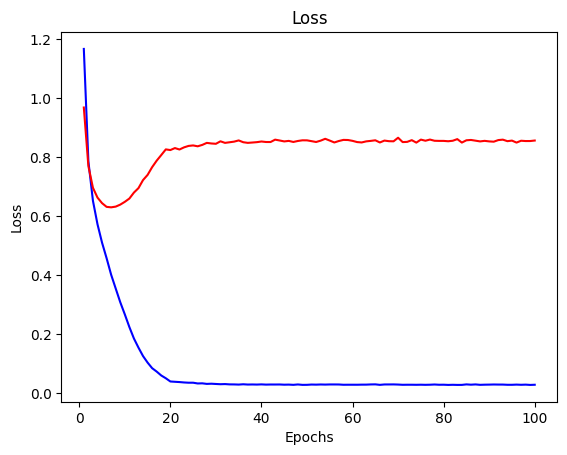

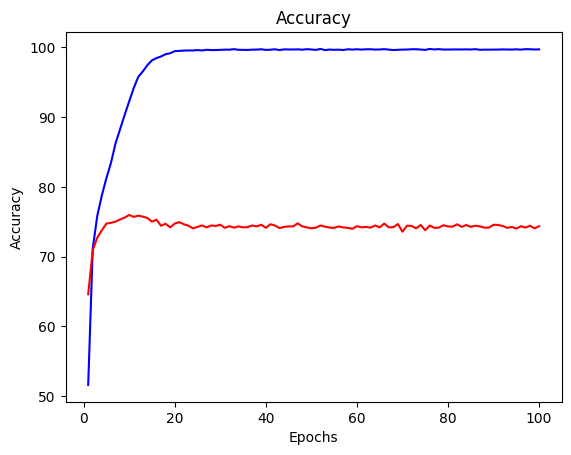

In [12]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Humanitarian_Classification_DenseNet121_pretrained Confusion Matrix:

affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0


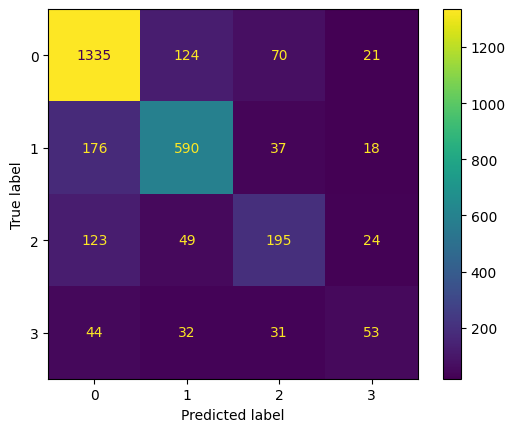

In [13]:
# "affected_injured_or_dead_people": 3, "rescue_volunteering_or_donation_effort": 2, "infrastructure_and_utility_damage": 1, "not_humanitarian": 0
print(task + '_DenseNet121_pretrained Confusion Matrix:\n')
print('affected_injured_or_dead_people: 3, rescue_volunteering_or_donation_effort: 2, infrastructure_and_utility_damage: 1, not_humanitarian: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()